In [1]:
import torch 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


In [2]:
x_train = torch.load("x_trainxl.pt")
y_train = torch.load("y_trainxl.pt")

In [3]:
x_train.shape

torch.Size([22833, 1, 15, 2000])

In [4]:
class ECGDataset():
      
    def __init__(self, data):
        self.data = data
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        return sample

In [5]:
import collections
import gc 
from pytorch_lightning.loggers import Logger 
from pytorch_lightning.loggers.logger import rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only

class HistoryLogger(Logger):
    def __init__(self):
        super().__init__()

        self.history = collections.defaultdict(list) # copy not necessary here
        self.log = collections.defaultdict(list) 
        self.loss = collections.defaultdict(list) 
        self.epoch = 1
        self.metric_names = []
        self.learning_rates = []  # To track learning rates
        # The defaultdict in contrast will simply create any items that you try to access

    @property
    def name(self):
        return "Logger"

    @property
    def version(self):
        return "1.0"

    @property
    @rank_zero_experiment
    def experiment(self):
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        
        for metric_name, metric_value in metrics.items():
            if metric_name != 'epoch':
                if metric_name not in self.metric_names:
                    self.metric_names.append(metric_name)
                self.history["temp"+metric_name].append(metric_value)
            
    def log_end_epoch(self): 

        for metric_name in self.metric_names:
            epoch_metric_values = self.history["temp"+metric_name]
            mean_metric = np.mean(epoch_metric_values)
            self.log[metric_name].append(mean_metric)
            self.loss[self.epoch] = epoch_metric_values

        #print(self.metric_names)
        # Log the learning rate for this epoch
        if self.learning_rates:
            self.log['learning_rate'].append(self.learning_rates[-1])  # Append the last recorded learning rate(s)
    
        self.epoch += 1
    
    def log_learning_rate(self, optimizer):
        """Logs the learning rate for each parameter group in the optimizer."""
        lrs = [param_group['lr'] for param_group in optimizer.param_groups]
        self.learning_rates.append(lrs)
        
    def log_hyperparams(self, params):
        pass

In [14]:
from pytorch_lightning import LightningModule

class ECGADLightning(LightningModule):
    
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.lr = lr
        self.metric = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = self.optimizer
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=10, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "mean_loss"}
    
    def training_step(self, batch, batch_idx):
        x = batch
        x_hat = self.model(x)
        loss = self.metric(x, x_hat)
        self.log_dict({"loss": loss}, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        self._shared_eval(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        self._shared_eval(batch, batch_idx, "test")

    def _shared_eval(self, batch, batch_idx, prefix):
        x = batch
        x_hat = self.model(x)
        loss = self.metric(x, x_hat)
        self.log(f"{prefix}_loss", loss)
        
    def on_train_epoch_end(self):
        
        self.logger.log_learning_rate(self.optimizer)
        self.logger.log_end_epoch() 
        self.log_dict({"mean_loss": self.logger.log["loss"][-1]}, sync_dist=True)
        #print(self.logger.log["loss"][-1])
        #clear_output()

In [15]:
from EcgStuffs.src.dpnet import dpnet_loader, conf
import torch 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    model = dpnet_loader.load() #load auto encoder model
else:
    model =  dpnet_loader.load_cpu()

In [16]:
model

DPNet(
  (encoder): Encoder(
    (conv_0): Conv2d(1, 15, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (activation0): Tanh()
    (conv_1): Conv2d(15, 30, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (activation1): Tanh()
    (block_0): EncoderBlock(
      (conv2d_in): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (activation_in): Tanh()
      (batch_norm_in): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_in): Dropout(p=0.2, inplace=False)
      (conv2d_out): Conv2d(30, 45, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (skip_con): Sequential(
        (0): Conv2d(30, 45, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (batch_norm_out): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_o

In [17]:
model.train()

DPNet(
  (encoder): Encoder(
    (conv_0): Conv2d(1, 15, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (activation0): Tanh()
    (conv_1): Conv2d(15, 30, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (activation1): Tanh()
    (block_0): EncoderBlock(
      (conv2d_in): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (activation_in): Tanh()
      (batch_norm_in): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_in): Dropout(p=0.2, inplace=False)
      (conv2d_out): Conv2d(30, 45, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (skip_con): Sequential(
        (0): Conv2d(30, 45, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (batch_norm_out): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_o

In [18]:
torch.set_float32_matmul_precision('medium')

In [23]:
from torch.utils.data import DataLoader

train_dataset = ECGDataset(x_train)
train_dataloader = DataLoader(train_dataset, batch_size = 8)#, num_workers=23)

In [24]:
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import os 

checkpoints_path = os.getcwd() + os.sep + "checkpoints"+ os.sep
epochs = 1000
logger = HistoryLogger()
checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
        filename="ptbxlmodel_ckpt_{epoch:02d}",
        every_n_epochs=100,
        save_top_k=-1,  # <--- this is important!
)
lightningmodel = ECGADLightning(model, lr = 0.001)#0.00001

In [25]:
trainer = Trainer(accelerator='gpu', precision=16, callbacks = [checkpoint_callback], max_epochs = epochs, logger= logger, log_every_n_steps = 1, default_root_dir=checkpoints_path,
check_val_every_n_epoch=100)#100
trainer.fit(lightningmodel, train_dataloader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type    | Params
-----------------------------------
0 | model  | DPNet   | 540 K 
1 | metric | MSELoss | 0     
-----------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [26]:
torch.save(model.state_dict(), "model_ptbxl2.pt")

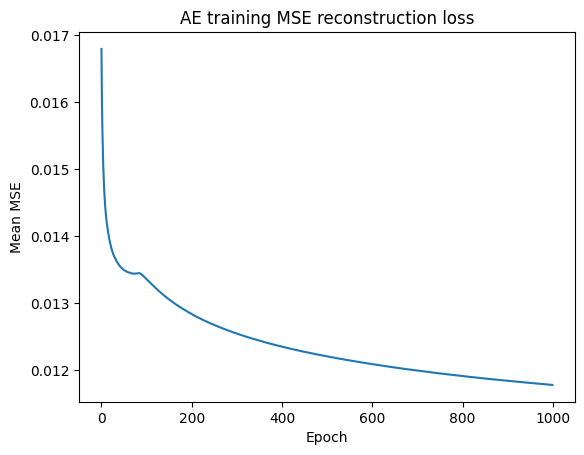

In [27]:
import matplotlib.pyplot as plt 

losses = logger.log["loss"]
fig = plt.Figure(figsize=(20, 10))
plt.title("AE training MSE reconstruction loss")
epochs_plot = np.arange(0, epochs, 1)
plt.plot(epochs_plot, losses)
plt.xlabel("Epoch")
plt.ylabel("Mean MSE")
plt.savefig("loss_ptbxl.png")

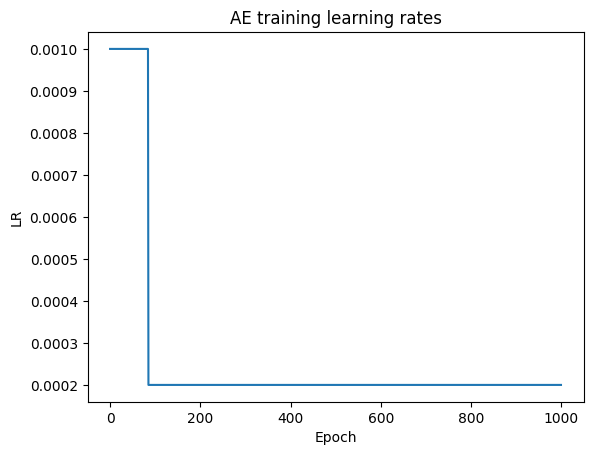

In [28]:
lrs = logger.learning_rates
fig = plt.Figure(figsize=(20, 10))
plt.title("AE training learning rates")
epochs_plot = np.arange(0, epochs, 1)
plt.plot(epochs_plot, lrs)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.savefig("learningrates_ptbxl.png")